### Notebook to analyse planes of satellites identified in TNG-50 as either _transient_ or _persistent_.

__(c) Till Sawala (2025). Please contact me at till.sawala@helsinki.fi with any issues or questions.__

__You are free to use any parts of this notebook, with appropriate attribution (see below).__

The notebook requires the `illustris_python` package: https://github.com/illustristng/illustris_python

It builds on the MW/M31 catalogue of Pillepich et al. (2024), https://www.tng-project.org/data/milkyway+andromeda/, and the TNG-50-1 merger trees, available at: https://www.tng-project.org/data/downloads/TNG50-1/

If you use parts of this script in your own work, I would appreciate a reference to the paper "Planes of satellites, at once transient and persistent". Of course, if you use the underlying simulation data, including the pre-computed data provided with this notebook, please also cite the relevant papers, as described here: https://www.tng-project.org/data/docs/background/#sec4

All positional computations are done in $[c\mathrm{kpc}/h]$. The MW/M31 catalogue uses physical positions $[\mathrm{kpc}]$ and is transformed when first read. Keep this in mind if you add additional simulation data.

Throughout the notebook, variables that refer to the _host-centric_ frame described in the paper will be called _transient_ (name contains `_trans`), while variables that refer to the _satellite-centric_ frame will be called _persistent_ (name contains `_pers`).

The parameters of this script that are meant to be changed are all defined below the cell **[Definitions](#Definitions)**. You can easily change, for example, the lookback time interval (`N_snap`), the number of satellites to consider (`N_sat`), or the definition of $r_{\mathrm lim}$ (via the `r_200_factor`). However, please note that some annotations of the plots are manually set for the specific values chosen in the paper and don't work for other parameter combinations. They will be placed when `paper_annotations` is `True` and omitted otherwise.

### Imports

In [1]:
import illustris_python as il
import numpy as np
import h5py
from pathlib import Path
import scipy.linalg as la
from scipy import spatial
from scipy import stats
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patheffects as patheffects
from matplotlib.gridspec import GridSpec
from tqdm import tqdm

### Definitions - intended to be changed

In [2]:
read_data = False   # Read the raw data. This requires downloading the TNG-50 data.
                    # If read_data == False, pre-computed data will be used,
                    # if it exists for the combination of parameters.

save_data = False   # Save the data (if the raw data was read).

N_MW = 1000 # limit to this number of MW halos (mainly for testing)

N_sat = 11 # choose the N satellites with the greatest stellar mass.

r200_factor = 1.2         # 1.2 is the assumed ratio between 300 kpc (commonly used)
                          # and the assumed r200 of the MW at z0, 250 kpc.
                          # We will select satellites within r200 * r200_factor in the simulation.

N_snap = 20 # how many snapshots do we include (incl. z=0). Use 20 for a lookback time of 3 Gyr

paper_annotations = True  # If True, the subset of systems shown in the paper
                          # is highlighted, and manual annotations are placed on some plots.
                          # This only makes sense for the combination of parameters in the paper,
                          # N_snap=20, r200_factor = 1.2, N_sat = 11.
                          # For other combinations, use paper_annotations == False.

### Define paths etc.

In [3]:
basePath = '/scratch/project_2010958/TNG50/' # Storage of the TNG 50 data. Required if read_data == True.

plot_dir = 'figures_rfac_'+str(np.round(r200_factor,1))+'_Nsat_'+str(N_sat)
save_dir = 'save_data'
save_data_file = save_dir+'/'+'rfac_'+str(np.round(r200_factor,1))+'_Nsat_'+str(N_sat)+'.npz'

if paper_annotations:
    plot_dir = plot_dir+'_paper'

Path(plot_dir).mkdir(exist_ok=True)

if save_data:
    Path(save_dir).mkdir(exist_ok=True)

if read_data:
    print ("reading raw data")

print ("plot directory:", plot_dir)
print ("save file:", save_data_file)

plot directory: figures_rfac_1.2_Nsat_11_paper
save file: save_data/rfac_1.2_Nsat_11.npz


### Define how the plots will look like.

In [4]:
cmap = mpl.colormaps['PuBu']
colors_pers = cmap( np.linspace(0.4,1., 11 ) ) # 11, to make the default colours look like in the paper.
c_pers_0 = colors_pers[8]
c_pers_1 = colors_pers[4]
colors_pers = cmap( np.linspace(0.4,1.,N_sat) )

cmap = mpl.colormaps['Reds']
colors_trans = cmap( np.linspace(0.4,1., 11) )
c_trans_0 = colors_trans[5]
c_trans_1 = colors_trans[2]
colors_trans = cmap( np.linspace(0.4,1.,N_sat) )


plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "dejavuserif"

styles = ['solid',(0, (6, 1.5)),(0, (2, 1.5)),(0, (4, 1.5, 2,1.5)) ] # line styles for the four highlighted systems.

# Highlight for the selected lines
pe = [patheffects.Stroke(linewidth=5, foreground='black'),
       patheffects.Stroke(foreground='white',alpha=1),
       patheffects.Normal()]

### Define the Lookback times and simulation parameters (this is from https://www.tng-project.org/data/downloads/TNG50-1/). Do not change these.

In [5]:
lookback_times = [13.624, 13.532, 13.433, 13.385, 13.328, 13.286, 13.256, 13.207, 13.163, 13.116, 13.071, 13.039, 12.959, 12.871, 12.838, 12.767, 12.691, 12.626, 12.521, 12.437, 12.337, 12.263, 12.115, 11.991, 11.859, 11.658, 11.565, 11.419, 11.264, 11.118, 10.964, 10.823, 10.674, 10.519, 10.356, 10.21, 10.059, 9.901, 9.766, 9.597, 9.51, 9.301, 9.147, 8.987, 8.823, 8.688, 8.514, 8.372, 8.226, 8.077, 7.925, 7.73, 7.61, 7.447, 7.281, 7.111, 6.981, 6.805, 6.671, 6.489, 6.35, 6.161, 6.017, 5.872, 5.724, 5.523, 5.371, 5.216, 5.06, 4.901, 4.741, 4.578, 4.414, 4.247, 4.079, 3.966, 3.794, 3.621, 3.504, 3.269, 3.149, 2.969, 2.787, 2.665, 2.48, 2.294, 2.169, 1.979, 1.852, 1.66, 1.466, 1.336, 1.14, 1.008, 0.81, 0.676, 0.475, 0.34, 0.136, 0][::-1]
redshifts = [20.05, 14.99, 11.98, 10.98, 10, 9.39, 9, 8.45, 8.01, 7.6, 7.24, 7.01, 6.49, 6.01, 5.85, 5.53, 5.23, 5, 4.66, 4.43, 4.18, 4.01, 3.71, 3.49, 3.28, 3.01, 2.9, 2.73, 2.58, 2.44, 2.32, 2.21, 2.1, 2, 1.9, 1.82, 1.74, 1.67, 1.6, 1.53, 1.5, 1.41, 1.36, 1.3, 1.25, 1.21, 1.15, 1.11, 1.07, 1.04, 1, 0.95, 0.92, 0.89, 0.85, 0.82, 0.79, 0.76, 0.73, 0.7, 0.68, 0.64, 0.62, 0.6, 0.58, 0.55, 0.52, 0.5, 0.48, 0.46, 0.44, 0.42, 0.4, 0.38, 0.36, 0.35, 0.33, 0.31, 0.3, 0.27, 0.26, 0.24, 0.23, 0.21, 0.2, 0.18, 0.17, 0.15, 0.14, 0.13, 0.11, 0.1, 0.08, 0.07, 0.06, 0.05, 0.03, 0.02, 0.01, 0][::-1]

scalefactors = 1 / (1 + np.array(redshifts))
lookback_times = np.array(lookback_times)

print ("Lookback time interval:", lookback_times[N_snap])

hubble = 0.6774
boxSize = 35000 # kpc

Lookback time interval: 3.269


### Functions for computing

In [6]:
# square roots of the eigenvalues and the eigenvectors of the full inertia tensor,
# using the numpy covariance function.

def inertiatensor (coords):
    
    covariance_matrix = np.cov([coords[:,0],coords[:,1],coords[:,2]])
    eigenvalues, eigenvectors = la.eigh(covariance_matrix)
    idx_sorted = eigenvalues.argsort()[::-1] #sort in decreasing order                          
    eigenvalues = eigenvalues[idx_sorted]
    eigenvectors = eigenvectors[:,idx_sorted]

    return np.sqrt(eigenvalues), eigenvectors


# returns the modified Gini coefficient, valid for small N (also called "sample Gini coefficient").
def gini_coefficient(array):
    array = array.flatten()
    if np.amin(array) < 0:
        array -= np.amin(array)
    # sort arguments
    array = np.sort(array)

    indices = np.arange(1,array.shape[0]+1)
    
    N = array.shape[0]
    
    return ((np.sum((2 * indices - N  - 1) * array)) / (np.sum(array))) / (N - 1.)



### Read the MW analogue sample at z=0, keeping only centrals.


In [7]:
if read_data:
    
    filename = "mwm31s_hostcatalog.hdf5"
    
    with h5py.File(filename, "r") as f:
    
        MW_M200_z0 = f['HaloMass_M200c'][()]
        MW_r200_z0 = f['HaloVirialRadius_R200c'][()]
        MW_ID_z0 = f['SubfindID'][()]
        MW_is_central_z0 = f['FlagCentral'][()]
        print("Keys: %s" % f.keys())
    
    print ("Number total:", len(MW_ID_z0))
    
    # keep only centrals:
    subset = np.nonzero(MW_is_central_z0)
    MW_M200_z0 = MW_M200_z0[subset]
    MW_r200_z0 = MW_r200_z0[subset]
    MW_ID_z0 = MW_ID_z0[subset]        # These are the IDs that can be used to identify the MW analogues in the merger trees.
    N_MW = min(N_MW, len(MW_ID_z0) )
    
    print ("Number of centrals:", N_MW)

### Find the satellites of each host at z=0, and select a subset of hosts where they can be traced.

First, we have to read the halo and subhalo catalogues. Then, we will look for the positions of all the hosts, and for all subhalos within $r_\mathrm{lim}$ around each host's position.

In [8]:
if read_data:
    fields = ['SubhaloPos', 'SubhaloGrNr', 'SubhaloMassType']
    subhalos = il.groupcat.loadSubhalos(basePath,99,fields=fields)

    MW_pos_z0 = subhalos['SubhaloPos'][MW_ID_z0]
    pos_z0 = subhalos['SubhaloPos']
    stellar_mass_z0 = subhalos['SubhaloMassType'][:,4] 
    
    length = len(pos_z0)
    print ("Total number of subhalos:", length)
    
    # select only subhalos with stars
    selection_z0 = np.nonzero(stellar_mass_z0)[0] # select only galaxies with stars.

    r_lim_z0 = r200_factor * MW_r200_z0 * hubble 
    
    print ("Total number of galaxies:", len(selection_z0))
    print ("Median MW_r200_z0:\n", np.median(MW_r200_z0))
    print ("Median W_M200_z0:\n", np.median(MW_M200_z0))

### Now loop over the Milky Ways and find the z=0 satellites using a KD tree.
Select the `N_sat` brightest satellites.

In [9]:
if read_data:
    
    subset = []
    print ("Building tree...")
    
    allPos = pos_z0[selection_z0].T
    for i in range(3):
        allPos[i][allPos[i] >= boxSize] = allPos[i][allPos[i] >= boxSize] - boxSize
        allPos[i][allPos[i] < 0.0] = allPos[i][allPos[i] < 0.0] + boxSize
    
    allPos = allPos.T
    tree = spatial.cKDTree(allPos, boxsize=boxSize)
    
    print ("Tree built.")
    
    # These are the neighbour lists of all the MW analogues (list of lists)
    NeighbourLists = tree.query_ball_point(MW_pos_z0, r_lim_z0)
    
    # We still need to get the subhalo numbers back from these, and
    # select the N with the greatest stellar masses, removing the MW analogue itself.
    
    Satellite_IDs_z0 = [] # This will hold the z = 0 satellite IDs for all MW analogues.
    
    for i_MW in range (N_MW):
    
        Satellite_idx = np.array(NeighbourLists[i_MW])
    
        # sort by stellar mass
        stellar_masses = stellar_mass_z0[selection_z0[Satellite_idx]]
    
        sorted_idx = np.argsort(stellar_masses)[::-1]  # sorted in descending order
    
        # this still includes the MW itself (highest stellar mass), so we remove it.
        Satellite_IDs = np.ravel(selection_z0)[Satellite_idx][sorted_idx][1:N_sat+1] 
    
        if len(Satellite_IDs) >= N_sat:
            Satellite_IDs_z0.append(Satellite_IDs)
            subset.append(i_MW) # systems with fewer satellites at z=0 are excluded.
    
    Satellite_IDs_z0 = np.array(Satellite_IDs_z0)
    
    print ("shape:", Satellite_IDs_z0.shape)
    print ("done finding satellites at z=0")


### Remove systems with too few satellites

In [10]:
if read_data:
    N_MW = len(subset)
    MW_ID_z0 = MW_ID_z0[subset]
    print ("N_MW", N_MW)

### Find the progenitors of the MW in the merger tree, and find the progenitors of the satellites in the merger tree.
We only keep systems where all `N_sat` satellites can be traced back for `N_snap` snapshots.


#### Get the positions of the MW progenitors:

In [11]:
if read_data:
    fields =  ['SubhaloPos', 'Group_R_Crit200']
    
    MW_pos_z = []
    MW_R200_z = []
    
    for i_MW in tqdm(range(N_MW)):
        
        tree = il.sublink.loadTree(basePath,99, MW_ID_z0[i_MW], fields=fields, onlyMPB=True)
        
        if tree != None : # some subhalos have no tree. 
            MW_pos_z_i = tree['SubhaloPos'][0:N_snap]
            MW_R200_z_i = tree['Group_R_Crit200'][0:N_snap]
        else:
            print ("MW progenitors not found. This should never happen")
    
        MW_pos_z.append(MW_pos_z_i)
        MW_R200_z.append(MW_R200_z_i)
    
    MW_pos_z = np.array(MW_pos_z)
    MW_R200_z = np.array(MW_R200_z)
    
    r_lim = r200_factor * MW_R200_z * scalefactors[0:N_snap] # radius for which we will look for satellites.
    


### Find the progenitors of the satellites in the _transient_ picture.

In [12]:
if read_data:
    
    fields = ['SubhaloPos','SubhaloPos']
    
    subset_MW_pers = []
    satellites_pos_z_pers = np.zeros((N_MW,N_sat,N_snap,3)) - 1.e10
    
    for i_MW in tqdm(range( N_MW) ) :
     
        # We only include systems where all the satellites can be traced back far enough.
    
        Satellites_pos_z_i = []
    
        if len(Satellite_IDs_z0[i_MW]) == N_sat : # if there are enough satellites at z=0. This should always be true.
    
            for i_sat in range(N_sat):
                    
                tree = il.sublink.loadTree(basePath,99, Satellite_IDs_z0[i_MW][i_sat],
                                           fields=fields,onlyMPB=True)
                if tree != None : # some subhalos have no tree.                         
                    Satellites_pos_z_i.append(tree['SubhaloPos'][0:N_snap])
    
        if len( np.concatenate(Satellites_pos_z_i).ravel()) == N_sat * N_snap * 3 :
            subset_MW_pers.append(i_MW)
            satellites_pos_z_pers[i_MW,:,:,:] = Satellites_pos_z_i
    
    subset_MW_pers = np.array(subset_MW_pers) # This is the subset of MW hosts that are
                                              # used for the "persistent" planes.
    
    print ("Number of analogues suitable for persistent picture:", len(subset_MW_pers))
    print ("done identifying pregenitors")
    
    print ("Satellites_pos_z_pers", satellites_pos_z_pers.shape)

## Find the hosts suitable for the _persistent_ picture.

#### Read information about galaxies irrespective of the merger tree

In [13]:
if read_data:
    snapnums = []
    stellar_masses = []
    positions = []
    
    for i_file in tqdm(range(0,9)):
    
        filename = "/scratch/project_2010958/TNG50/trees/SubLink/tree_extended."+str(i_file)+".hdf5"
    
        with h5py.File(filename, "r") as f:
        
            file_stellar_masses =  f['SubhaloMassType'][()][:,4]
            stellar_masses.append(file_stellar_masses) # list of numpy arrays
    
            file_snapnums =  f['SnapNum'][()]
            snapnums.append(file_snapnums) # list of numpy arrays
    
            file_positions = f['SubhaloPos'][()]
            positions.append(file_positions) # list of numpy arrays
    
    snapnums = np.hstack(snapnums)
    stellar_masses = np.hstack(stellar_masses)
    positions = np.concatenate(positions, axis = 0)
    
    print ("Total number of subhalos read:", len(snapnums))

In [14]:
if read_data:
    subset_MW_trans = []
    
    N_found_MW = np.zeros(N_MW) # this array holds the total number of progenitors found.
                                # If all satellites have progenitors at all outputs, it should be
                                # equal to N_snap.
    
    satellites_pos_z_trans = np.zeros((N_MW,N_snap,N_sat,3)) - 1.e10
    
    
    for i_snap in tqdm (range(0,N_snap)):
    
        satellites_pos_z_trans_snap = []
    
        selection_snap = np.where( (snapnums == 99 - i_snap) & (stellar_masses > 0) )[0] 
    
        positions_snap = positions[selection_snap,:]
    
        allPos = positions_snap.T
        for i in range(3):
            allPos[i][allPos[i] >= boxSize] = allPos[i][allPos[i] >= boxSize] - boxSize
            allPos[i][allPos[i] < 0.0] = allPos[i][allPos[i] < 0.0] + boxSize
        
        allPos = allPos.T
        tree = spatial.cKDTree(allPos, boxsize=boxSize)
        
        NeighbourLists = tree.query_ball_point(MW_pos_z[:,i_snap,:], r_lim[:,i_snap])
    
        # We still need to get the subhalo numbers back from these and
        # select the N with the greatest stellar masses, removing the MW analogue itself.
    
        Satellite_IDs_z_trans = [] 
    
        for i_MW in range(N_MW):
            
            Satellite_IDs = np.ravel(selection_snap)[ NeighbourLists[i_MW]]
            
            # these are the indices in the full arrays.
    
            if len(Satellite_IDs) >= N_sat+1: # this still includes the MW itself. 
        
                N_found_MW[i_MW] += 1
    
                # we may consider both the stellar mass and the radius.
                these_stellar_masses = stellar_masses[Satellite_IDs]    
                these_positions = positions[Satellite_IDs]
    
                # We exclude subhalos that are the MW itself
                MW_distance_x = np.abs((these_positions[:,0] - MW_pos_z[i_MW,i_snap,0]))
    
                sorted_IDs = np.argsort(these_stellar_masses[MW_distance_x > 1.e-10])[::-1]  # sorted in descending order
    
                # We normally assume that the progenitor of the MW is the most massive galaxy in the radius.
                # However, this is not necesarily true, so we have to check, and exclude it if necessary.
    
                Satellite_IDs = Satellite_IDs[MW_distance_x > 1.e-10][sorted_IDs][0:N_sat]        # The IDs selected.
                satellites_pos_z_trans[i_MW, i_snap, :, :] = positions[Satellite_IDs]
    
    satellites_pos_z_trans = np.moveaxis(satellites_pos_z_trans, 1, 2)
    
    for i_MW in range (N_MW):
        if N_found_MW[i_MW] == N_snap:
            subset_MW_trans.append(i_MW)
    
    subset_MW_trans = np.array(subset_MW_trans)
    #satellites_pos_z_trans = satellites_pos_z_trans[subset_MW_trans]
    
    print ("Number of analogues suitable for transient picture:", len(subset_MW_trans))

### Compute the union of subsets to define the subset we will use.

### Remove system(s) with large jumps in $r_{200}$ during the lookback time interval.
A large jump $r_{200}$ causes discontinuity in the satellite definition. With the default parameters, this affects only one system.

In [15]:
if read_data:

    union = list ( set(subset_MW_trans) & set(subset_MW_pers) )

    subset = []
    for i_MW in range (len(union)):    
        x = r_lim[union[i_MW],:]
        ratios = x[:-1]/x[1:]
    
        if np.min(ratios) < 0.9 or np.max(ratios) > 1.1 :
        
            print ("i:", i_MW, np.min(ratios), np.max(ratios))
        else:
            subset.append(union[i_MW])

    subset = np.array(subset)

    print (subset.shape)

### Write the data to a file.

In [16]:
if read_data and save_data:
    np.savez(save_data_file,
             subset = subset,
             satellites_pos_z_trans = satellites_pos_z_trans,
             satellites_pos_z_pers = satellites_pos_z_pers,
             MW_pos_z = MW_pos_z,
             MW_ID_z0 = MW_ID_z0,
             MW_M200_z0 = MW_M200_z0,
             r_lim = r_lim )

    print ("saved")   

### Restore data from the file.

In [17]:
if read_data == False:
    data = np.load(save_data_file)
    
    subset = np.array(data['subset'])
    satellites_pos_z_trans = np.array(data['satellites_pos_z_trans'])
    satellites_pos_z_pers = np.array(data['satellites_pos_z_pers'])
    MW_pos_z = np.array(data['MW_pos_z'])
    MW_M200_z0 = data['MW_M200_z0']
    MW_ID_z0 = np.array(data['MW_ID_z0'])
    r_lim = data['r_lim']

    
    print ("read back")

read back


#### Now, with these subsets, we can make a new selection of hosts and assume that they are found.
#### We can also compare the objects 1:1 in both pictures.

In [18]:
N_MW = len(subset)

### compare _persistent_ and _transient_ 1:1 

In [19]:
pos_trans = np.remainder(satellites_pos_z_trans[subset] - MW_pos_z[subset, None, :, :] + boxSize/2., boxSize) - boxSize/2.
pos_pers = np.remainder(satellites_pos_z_pers[subset] - MW_pos_z[subset, None, :, :] + boxSize/2., boxSize) - boxSize/2.

# Pre-allocate arrays
ca_z_trans = np.zeros((N_MW, N_snap))
ca_z_pers = np.zeros((N_MW, N_snap))
gini_z_trans = np.zeros((N_MW, N_snap))
gini_z_pers = np.zeros((N_MW, N_snap))
r_z_trans = np.zeros((N_MW, N_snap, pos_trans.shape[1]))  # Assuming shape: (MW, satellites, snap, coords)
r_z_pers = np.zeros((N_MW, N_snap, pos_pers.shape[1]))

# Compute ca (and Gini coefficients)
for i_MW in range(N_MW):
    for i_snap in range(N_snap):
        # Process transient data
        positions_trans = pos_trans[i_MW, :, i_snap, :]
        evs_trans = inertiatensor(positions_trans)[0]
        ca_z_trans[i_MW, i_snap] = evs_trans[2] / evs_trans[0]
        
        r_trans = np.linalg.norm(positions_trans, axis=1)
        r_z_trans[i_MW, i_snap, :] = r_trans
        gini_z_trans[i_MW, i_snap] = gini_coefficient(r_trans**2)
        
        # Process persistent data
        positions_pers = pos_pers[i_MW, :, i_snap, :]
        evs_pers = inertiatensor(positions_pers)[0]
        ca_z_pers[i_MW, i_snap] = evs_pers[2] / evs_pers[0]
        
        r_pers = np.linalg.norm(positions_pers, axis=1)
        r_z_pers[i_MW, i_snap, :] = r_pers
        gini_z_pers[i_MW, i_snap] = gini_coefficient(r_pers**2)

print("transient and persistent computed")
print("len ca_trans:", len(ca_z_trans)) 
print("len ca_pers:", len(ca_z_pers))

transient and persistent computed
len ca_trans: 101
len ca_pers: 101


In [20]:
print ("5 highest gini (z=0)", np.sort(gini_z_pers[:, 0])[-6:-1] )
print ("5 lowest ca_z (z=0)", np.sort(ca_z_pers[:, 0])[0:5] )

5 highest gini (z=0) [0.59822779 0.61101879 0.63029549 0.63121832 0.65402988]
5 lowest ca_z (z=0) [0.2357953  0.23587414 0.24739073 0.25471864 0.25533365]


### Define subsets of satellites, ordered by various properties

In [21]:
# ca at z=0 
idx_sorted_ca_trans = np.argsort(ca_z_trans[:,0])
idx_sorted_ca_pers = np.argsort(ca_z_pers[:,0])

# maximum c/a value attained during the period

max_ca_trans = np.max(ca_z_trans, axis = 1)
max_ca_pers = np.max(ca_z_pers, axis = 1)

idx_sorted_max_ca_trans = np.argsort(max_ca_trans)
idx_sorted_max_ca_pers = np.argsort(max_ca_pers)

print ("lowest max ca values (pers):", max_ca_pers[ idx_sorted_max_ca_pers[0:5] ] )
print ("lowest max ca values (trans):", max_ca_trans[ idx_sorted_max_ca_trans[0:5] ])

print ("indices:", idx_sorted_max_ca_pers[0:4])

highlighted = idx_sorted_max_ca_pers[0:4] # we highlight these four systems in the paper


lowest max ca values (pers): [0.32786123 0.33775044 0.35600745 0.37294097 0.39209387]
lowest max ca values (trans): [0.42623584 0.48966084 0.49515617 0.50337352 0.51443563]
indices: [36 15 35 40]


In [22]:
idx_low_ca_0 = idx_sorted_ca_trans[0:int(len(idx_sorted_ca_trans) / 4)] # we plot systems in the 1st quartile.
print ("Number of systems in the first quartile:", len(idx_low_ca_0))

Number of systems in the first quartile: 25


### Compute when the "transient" satellites sample has changed for the first time.

In [23]:
# compute when the "transient" satellites sample has changed for the first time.

first_changed = []

for i_MW in range(len(subset)):
    for snap in range(N_snap):
        positions_trans = np.remainder(satellites_pos_z_trans[subset[i_MW], :, snap, :] - MW_pos_z[subset[i_MW], snap, np.newaxis] + 
                                      boxSize/2., boxSize) - boxSize/2.
        
        positions_pers = np.remainder(satellites_pos_z_pers[subset[i_MW], :, snap, :] - MW_pos_z[subset[i_MW], snap, np.newaxis] + 
                                     boxSize/2., boxSize) - boxSize/2.
        
        diff = positions_trans[:, np.newaxis, :] - positions_pers[np.newaxis, :, :]
        distances = np.linalg.norm(diff, axis=2)
        min_distances = np.min(distances, axis=1)
        
        if len(np.where(min_distances > 1.e-5)[0]) > 0: # if there is a satellite not in the persistent set.
            first_changed.append(snap)
            break

first_changed = np.array(first_changed)


### Compute the number of subhalos in the _transient_ samples that were present at t=0.

This is done by comparing their positions to those of the persistent sample, which are, by definition, the same as at t=0.

In [24]:
N_OG = []

for i_MW in range(len(subset)):

    N_OG_i = []
    
    for snap in range(N_snap):
        positions_trans = np.remainder(satellites_pos_z_trans[subset[i_MW], :, snap, :] - MW_pos_z[subset[i_MW], snap, np.newaxis] + 
                                      boxSize/2., boxSize) - boxSize/2.
        
        positions_pers = np.remainder(satellites_pos_z_pers[subset[i_MW], :, snap, :] - MW_pos_z[subset[i_MW], snap, np.newaxis] + 
                                     boxSize/2., boxSize) - boxSize/2.
        
        diff = positions_trans[:, np.newaxis, :] - positions_pers[np.newaxis, :, :]
        distances = np.linalg.norm(diff, axis=2)
        min_distances = np.min(distances, axis=1)

        N_OG_i.append(len(np.where(min_distances < 1.e-5)[0]) )
        
    N_OG.append(N_OG_i)

N_OG_z = np.array(N_OG)

print ("shape N_OG:", N_OG_z.shape)

shape N_OG: (101, 20)


## Compute the number of subhalos still within $r_\mathrm{lim}$ in the _persistent_ samples.

In [25]:
# Reshape r_lim to match the dimensions of r_z_pers:
r_lim_reshaped = r_lim[subset[:, np.newaxis], np.arange(N_snap)[np.newaxis, :], np.newaxis]

# Compare and count:
N_inside_z = np.sum(r_z_pers < r_lim_reshaped, axis=2)

print ("shape N_inside_z:", N_inside_z.shape)


shape N_inside_z: (101, 20)


### Plot $c/a$, highlighting selected systems

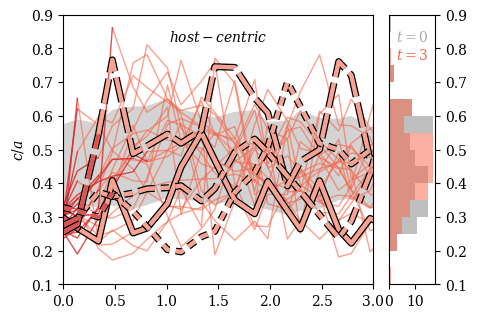

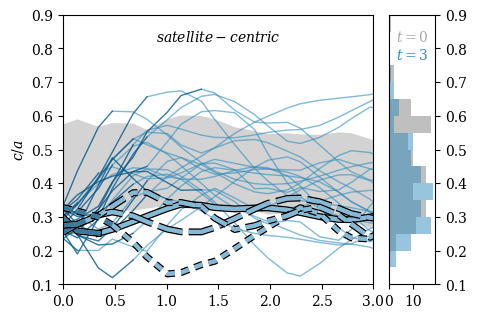

In [26]:
# TRANS

fig, ax = plt.subplots(figsize=(4,3.5))

ca_plus1 = np.percentile(ca_z_trans, 84.135, axis = 0)
ca_minus1 = np.percentile(ca_z_trans, 15.865, axis = 0)

x_offset = -0.1 # numbers can overlap
offsets = [-0.05,+0.05,0,0]

count = 0



for i_MW in range(len(subset)):
    
    if paper_annotations and i_MW in highlighted:
        params_dark = {'alpha' : .8, 'lw' : 3., 'color' : c_trans_0, 'zorder' : 1, 'ls':styles[count]}
        params_light = {'alpha' : .6, 'lw' : 3., 'color' :  c_trans_1, 'zorder' : 0, 'ls':styles[count]}
        count = count+1
    else:
        params_dark = {'alpha' : .8, 'lw' : 1., 'color' : c_trans_0, 'zorder' : -1}
        params_light = {'alpha' : .6, 'lw' : 1., 'color' : c_trans_1, 'zorder' : -2}

    if i_MW in idx_low_ca_0:

        dark = np.where(np.minimum.accumulate(N_OG_z[i_MW]) == N_sat)[0]
        dark = list(dark)
        if max(dark) < N_snap -1 :
            dark.append(dark[-1]+1)
        dark = np.array(dark)
        light = np.where(np.minimum.accumulate(N_OG_z[i_MW]) < N_sat )[0]

        if paper_annotations and i_MW in highlighted:
            ax.plot(lookback_times[dark], ca_z_trans[i_MW,dark], **params_dark, path_effects = pe) 
            ax.plot(lookback_times[light], ca_z_trans[i_MW,light], **params_light, path_effects = pe) 
      
        else:
            
            ax.plot(lookback_times[dark], ca_z_trans[i_MW,dark], **params_dark) 
            ax.plot(lookback_times[light], ca_z_trans[i_MW,light], **params_light) 
    
ax.fill_between(lookback_times[0:N_snap], ca_minus1, ca_plus1, fc = 'lightgrey', alpha = 1, zorder = -10 ) 
   
ax.set(ylabel=r'$c/a$')
ax.set_xlim(0,np.round(lookback_times[N_snap-1]))
ax.set_ylim(0.1,0.9)

ax_histy = ax.inset_axes([1.05, 0, 0.15, 1], sharey=ax)
edges = np.linspace(0, 1., num=21)
ax_histy.hist( ca_z_trans[:,0], bins=edges, orientation='horizontal', color = 'grey', alpha = .5)
ax_histy.hist( ca_z_trans[:,-1], bins=edges, orientation='horizontal', color = c_trans_1, alpha = .5)
ax_histy.yaxis.set_label_position("right")
ax_histy.yaxis.tick_right()

ax.text(0.5, 0.92, r'$host-centric$', ha='center', va='center', transform=ax.transAxes)
ax_histy.text(0.5, 0.92, r'$t=0$', ha='center', va='center', color='darkgrey', transform=ax_histy.transAxes)
ax_histy.text(0.5, 0.85, r'$t=3$', ha='center', va='center', color=c_trans_1, transform=ax_histy.transAxes)

fig.savefig(plot_dir+"/"+"ca_time_transient.pdf", bbox_inches='tight')


# PERS

fig, ax = plt.subplots(figsize=(4,3.5))

ca_plus1 = np.percentile(ca_z_pers, 84.135, axis = 0)
ca_minus1 = np.percentile(ca_z_pers, 15.865, axis = 0)


count = 0

for i_MW in range(len(subset)):


    if paper_annotations and i_MW in highlighted:
        params_dark = {'alpha' : .8, 'lw' : 3., 'color' : c_pers_0, 'zorder' : 1, 'ls':styles[count]}
        params_light = {'alpha' : .6, 'lw' : 3., 'color' :  c_pers_1, 'zorder' : 0, 'ls':styles[count]}
        count = count+1
    else:
        params_dark = {'alpha' : .8, 'lw' : 1., 'color' : c_pers_0, 'zorder' : -1}
        params_light = {'alpha' : .6, 'lw' : 1., 'color' : c_pers_1, 'zorder' : -2}

    if i_MW in idx_low_ca_0:

        dark = np.where(np.minimum.accumulate(N_inside_z[i_MW]) == N_sat)[0]
        dark = list(dark)
        if max(dark) < N_snap -1 :
            dark.append(dark[-1]+1)
        dark = np.array(dark)
        light = np.where(np.minimum.accumulate(N_inside_z[i_MW]) < N_sat )[0]

        if paper_annotations and i_MW in highlighted:
            ax.plot(lookback_times[dark], ca_z_pers[i_MW,dark], **params_dark, path_effects = pe) 
            ax.plot(lookback_times[light], ca_z_pers[i_MW,light], **params_light, path_effects = pe) 
      
        else:
            
            ax.plot(lookback_times[dark], ca_z_pers[i_MW,dark], **params_dark) 
            ax.plot(lookback_times[light], ca_z_pers[i_MW,light], **params_light) 
    
 
ax.fill_between(lookback_times[0:N_snap], ca_minus1, ca_plus1, fc = 'lightgrey', alpha = 1, zorder = -10 ) 

ax.set(ylabel=r'$c/a$')
ax.set_xlim(0,np.round(lookback_times[N_snap-1]))
ax.set_ylim(0.1,0.9)

ax_histy = ax.inset_axes([1.05, 0, 0.15, 1], sharey=ax)
edges = np.linspace(0, 1., num=21)
ax_histy.hist( ca_z_pers[:,0], bins=edges, orientation='horizontal', color = 'grey', alpha = .5)
ax_histy.hist( ca_z_pers[:,-1], bins=edges, orientation='horizontal', color = c_pers_1, alpha = .5)
ax_histy.yaxis.set_label_position("right")
ax_histy.yaxis.tick_right()

ax.text(0.5, 0.92, r'$satellite-centric$', ha='center', va='center', transform=ax.transAxes)
ax_histy.text(0.5, 0.92, r'$t=0$', ha='center', va='center', color='darkgrey', transform=ax_histy.transAxes)
ax_histy.text(0.5, 0.85, r'$t=3$', ha='center', va='center', color=c_pers_1, transform=ax_histy.transAxes)

fig.savefig(plot_dir+"/"+"ca_time_persistent.pdf", bbox_inches='tight')


## Plot $\Delta(c/a) / \Delta t$ 

lookback_times[0:N_snap-1] [0.    0.136 0.34  0.475 0.676 0.81  1.008 1.14  1.336 1.466 1.66  1.852
 1.979 2.169 2.294 2.48  2.665 2.787 2.969]
len: 20
Nsnap: 20


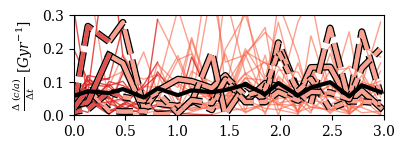

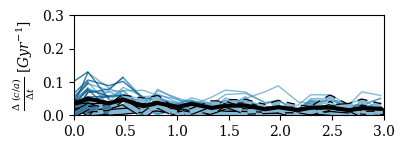

In [27]:
# TRANS

fig, ax = plt.subplots(figsize=(4,1.3))

median_delta_ca = np.mean( np.abs(np.diff(ca_z_trans)), axis = 0 )

count = 0

for i_MW in range(len(subset)):
    
    if paper_annotations and i_MW in highlighted:
        params_dark = {'alpha' : .8, 'lw' : 3., 'color' : c_trans_0, 'zorder' : 1, 'ls':styles[count]}
        params_light = {'alpha' : .6, 'lw' : 3., 'color' :  c_trans_1, 'zorder' : 0, 'ls':styles[count]}
        count = count+1
    else:
        params_dark = {'alpha' : .8, 'lw' : 1., 'color' : c_trans_0, 'zorder' : -1}
        params_light = {'alpha' : .6, 'lw' : 1., 'color' : c_trans_1, 'zorder' : -2}

    if i_MW in idx_low_ca_0:
        
        dark = np.where(np.minimum.accumulate(N_inside_z[i_MW]) == N_sat)[0]
        dark = list(dark)
        if max(dark) < N_snap -1 :
            dark.extend([dark[-1]+1, dark[-1]+2])

        dark = np.array(dark)
        light = np.where(np.minimum.accumulate(N_inside_z[i_MW]) < N_sat )[0]

        if paper_annotations and i_MW in highlighted:
            ax.plot(lookback_times[dark[:-1]], np.abs(np.diff(ca_z_trans[i_MW,dark])), **params_dark, path_effects = pe) 
            ax.plot(lookback_times[light[:-1]], np.abs(np.diff(ca_z_trans[i_MW,light])), **params_light, path_effects = pe) 
      
        else:
            
            ax.plot(lookback_times[dark[:-1]], np.abs(np.diff(ca_z_trans[i_MW,dark])), **params_dark) 
            ax.plot(lookback_times[light[:-1]], np.abs(np.diff(ca_z_trans[i_MW,light])), **params_light) 

ax.plot(lookback_times[0:N_snap-1], median_delta_ca, color = 'black', lw = 3, ls = 'solid', zorder = 200) 

ax.set(xlabel='', ylabel=r'$\frac{\Delta \ (c/a)}{\Delta t} \ [Gyr^{-1}]$')
ax.set_xlim(0,np.round(lookback_times[N_snap-1]))
ax.set_ylim(0.0,0.3)

fig.savefig(plot_dir+"/"+"delta_ca_time_transient.pdf", bbox_inches='tight')

# PERS

fig, ax = plt.subplots(figsize=(4,1.3))

count = 0

median_delta_ca = np.mean( np.abs(np.diff(ca_z_pers)) , axis = 0 )

for i_MW in range(len(subset)):


    if paper_annotations and i_MW in highlighted:
        params_dark = {'alpha' : .8, 'lw' : 3., 'color' : c_pers_0, 'zorder' : 1, 'ls':styles[count]}
        params_light = {'alpha' : .6, 'lw' : 3., 'color' :  c_pers_1, 'zorder' : 0, 'ls':styles[count]}
        count = count+1
    else:
        params_dark = {'alpha' : .8, 'lw' : 1., 'color' : c_pers_0, 'zorder' : -1}
        params_light = {'alpha' : .6, 'lw' : 1., 'color' : c_pers_1, 'zorder' : -2}

    if i_MW in idx_low_ca_0:
        
        dark = np.where(np.minimum.accumulate(N_OG_z[i_MW]) == N_sat)[0]
        dark = list(dark)
        if max(dark) < N_snap -1 :
            dark.extend([dark[-1]+1, dark[-1]+2])

        dark = np.array(dark)
        light = np.where(np.minimum.accumulate(N_OG_z[i_MW]) < N_sat )[0]

        if paper_annotations and i_MW in highlighted:
            ax.plot(lookback_times[dark[:-1]], np.abs(np.diff(ca_z_pers[i_MW,dark])), **params_dark, path_effects = pe) 
            ax.plot(lookback_times[light[:-1]], np.abs(np.diff(ca_z_pers[i_MW,light])), **params_light, path_effects = pe) 
      
        else:
            ax.plot(lookback_times[dark[:-1]], np.abs(np.diff(ca_z_pers[i_MW,dark])), **params_dark) 
            ax.plot(lookback_times[light[:-1]], np.abs(np.diff(ca_z_pers[i_MW,light])), **params_light) 
        
ax.plot(lookback_times[0:N_snap-1], median_delta_ca, color = 'black', lw = 3, ls = 'solid', zorder = 200) 
    
ax.set(xlabel='', ylabel=r'$\frac{\Delta \ (c/a)}{\Delta t} \ [Gyr^{-1}]$')
ax.set_xlim(0,np.round(lookback_times[N_snap-2],1))
ax.set_ylim(0.0,0.3)

fig.savefig(plot_dir+"/"+"delta_ca_time_persistent.pdf", bbox_inches='tight')

print ("lookback_times[0:N_snap-1]", lookback_times[0:N_snap-1])
print ("len:", len(ca_z_trans[0,:]))
print ("Nsnap:", N_snap)

## Plot max($c/a$) over time

sigma: 0.12744292396805448


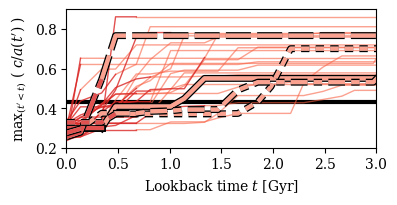

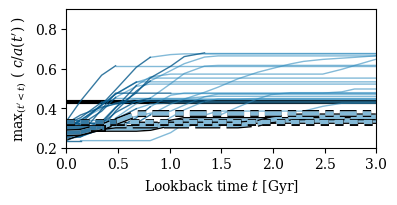

In [28]:
# TRANS

sigma = np.std(ca_z_trans[:,0])
print ("sigma:", sigma)

fig, ax = plt.subplots(figsize=(4,1.8))

count = 0

for i_MW in range(len(subset)):

    if paper_annotations and i_MW in highlighted:
        params_dark = {'alpha' : .8, 'lw' : 3., 'color' : c_trans_0, 'zorder' : 1, 'ls':styles[count]}
        params_light = {'alpha' : .6, 'lw' : 3., 'color' :  c_trans_1, 'zorder' : 0, 'ls':styles[count]}
        count = count+1
    else:
        params_dark = {'alpha' : .8, 'lw' : 1., 'color' : c_trans_0, 'zorder' : -1}
        params_light = {'alpha' : .6, 'lw' : 1., 'color' : c_trans_1, 'zorder' : -2}

    if i_MW in idx_low_ca_0:

        max_ca = np.maximum.accumulate(ca_z_trans[i_MW,:])

        dark = np.where(np.minimum.accumulate(N_inside_z[i_MW]) == N_sat)[0]
        dark = list(dark)
        if max(dark) < N_snap -1 :
            dark.append(dark[-1]+1)
        dark = np.array(dark)
        light = np.where(np.minimum.accumulate(N_inside_z[i_MW]) < N_sat )[0]

        if paper_annotations and i_MW in highlighted:
            ax.plot(lookback_times[dark], max_ca[dark], **params_dark, path_effects = pe) 
            ax.plot(lookback_times[light], max_ca[light], **params_light, path_effects = pe) 
      
        else:
            ax.plot(lookback_times[dark], max_ca[dark], **params_dark) 
            ax.plot(lookback_times[light], max_ca[light], **params_light)     
ax.set(xlabel='Lookback time '+r'$t$'+' [Gyr]',  ylabel=r'$\mathrm{max}_{(t^\prime < t)} \ \left(\ c/a(t^\prime)\ \right)$')
ax.set_xlim(0,np.round(lookback_times[N_snap-1]))
ax.set_ylim(0.2,.9)
ax.axhline([np.median(ca_z_trans[:,0])], ls = 'solid', color = 'black', lw = 3, zorder = -200)

fig.savefig(plot_dir+"/"+"max_ca_time_transient.pdf", bbox_inches='tight')

# PERS

fig, ax = plt.subplots(figsize=(4,1.8))

count = 0

for i_MW in range(len(subset)):


    if paper_annotations and i_MW in highlighted:
        params_dark = {'alpha' : .8, 'lw' : 3., 'color' : c_pers_0, 'zorder' : 1, 'ls':styles[count]}
        params_light = {'alpha' : .6, 'lw' : 3., 'color' :  c_pers_1, 'zorder' : 0, 'ls':styles[count]}
        count = count+1
    else:
        params_dark = {'alpha' : .8, 'lw' : 1., 'color' : c_pers_0, 'zorder' : -1}
        params_light = {'alpha' : .6, 'lw' : 1., 'color' : c_pers_1, 'zorder' : -2}

    if i_MW in idx_low_ca_0:

        max_ca = np.maximum.accumulate(ca_z_pers[i_MW,:])

        dark = np.where(np.minimum.accumulate(N_inside_z[i_MW]) == N_sat)[0]
        dark = list(dark)
        if max(dark) < N_snap -1 :
            dark.append(dark[-1]+1)
        dark = np.array(dark)
        light = np.where(np.minimum.accumulate(N_inside_z[i_MW]) < N_sat )[0]

        if paper_annotations and i_MW in highlighted:
            ax.plot(lookback_times[dark], max_ca[dark], **params_dark, path_effects = pe) 
            ax.plot(lookback_times[light], max_ca[light], **params_light, path_effects = pe) 
      
        else:
            ax.plot(lookback_times[dark], max_ca[dark], **params_dark) 
            ax.plot(lookback_times[light], max_ca[light], **params_light) 
    

ax.set(xlabel='Lookback time '+r'$t$'+' [Gyr]',  ylabel=r'$\mathrm{max}_{(t^\prime < t)} \ \left(\ c/a(t^\prime)\ \right)$')
ax.set_xlim(0,np.round(lookback_times[N_snap-1]))
ax.set_ylim(0.2,.9)
ax.axhline([np.median(ca_z_pers[:,0])], ls = 'solid', color = 'black', lw = 3, zorder = -200)

fig.savefig(plot_dir+"/"+"max_ca_time_persistent.pdf", bbox_inches='tight')

# np.maximum.accumulate(np.abs(ca_z_pers[i_MW,:] - ca_z_trans[i_MW,0,np.newaxis]))

In [29]:
print (ca_z_pers[idx_low_ca_0,0])

[0.2357953  0.23587414 0.24739073 0.25471864 0.25533365 0.25885819
 0.27032243 0.27339542 0.2751098  0.27933239 0.29105038 0.29429964
 0.29678835 0.29759083 0.30254919 0.30267731 0.30346444 0.31595797
 0.31986004 0.32228138 0.32288949 0.32429443 0.32786123 0.33427734
 0.33762706]


## Plot fraction of systems still containing N satellites within $r_\mathrm{lim}$ in the _persistent_ picture

thresholds: [11 10  9  8  7  6]


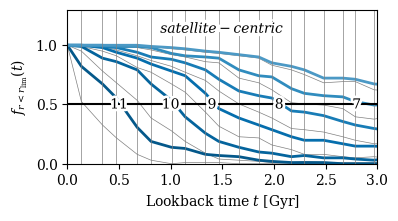

In [30]:
thresholds = N_sat - np.array([0, 1, 2, 3, 4, 5])

print ("thresholds:", thresholds)

# Calculate counts for all thresholds (TRANS)
counts_trans = np.sum(N_OG_z[:, :, np.newaxis] >= np.array(thresholds)[np.newaxis, np.newaxis, :], axis=0)

# Calculate counts for all thresholds (PERS)
counts_pers = np.sum(N_inside_z[:, :, np.newaxis] >= np.array(thresholds)[np.newaxis, np.newaxis, :], axis=0)

# Plot all lines
fig, ax = plt.subplots(figsize=(4, 2))


for i, threshold in enumerate(thresholds):
    ax.plot(lookback_times[0:N_snap], counts_pers[:, i] / len(subset), 
            color=colors_pers[8-i], lw = 2., alpha=1 )

    ax.plot(lookback_times[0:N_snap], counts_trans[:, i] / len(subset), 
            color='grey', alpha=1, lw = .5, zorder = -20)


ax.set(xlabel='Lookback time '+r'$t$'+' [Gyr]', ylabel=r'$f_{r < r_\mathrm{lim}}(t)$')
ax.set_xlim(0,3)
ax.set_ylim(0,1.3)
ax.set_yticks([0, 0.5, 1])
ax.set_xticks([0.,0.5,1.,1.5,2.,2.5,3.])

ax.vlines(np.array(lookback_times[0:N_snap]) , ymin=0, ymax=250, ls = 'solid', lw = 0.5, color ='grey')

ax.axhline([0.5], color = 'black')

x = np.array([0.5, 1., 1.4, 2.05, 2.8])
y = np.array([0.5, 0.5, 0.5, 0.5, 0.5])

ax.text(0.5, 0.88, r'$satellite-centric$', ha='center', va='center', transform=ax.transAxes, 
                        path_effects=[patheffects.withStroke(linewidth=5, foreground='white', capstyle="round")],
                        )
if paper_annotations:
    for i in range(5):
        ax.text(x[i], y[i], str(11-i), ha='center', va='center', 
                path_effects=[patheffects.withStroke(linewidth=4, foreground='white', capstyle="round")],
                transform=ax.transData)

fig.savefig(plot_dir+"/"+"histogram_inside_pers.pdf", bbox_inches='tight')

## Plot fraction of systems containing N satellites of the $z=0$ sample in the _transient_ picture.

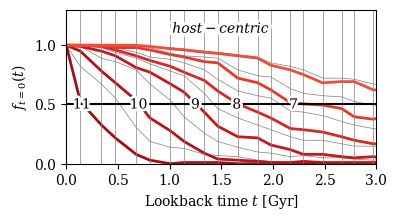

In [31]:
thresholds = N_sat - np.array([0, 1, 2, 3, 4, 5])

# Calculate counts for all thresholds (TRANS)
counts_trans = np.sum(N_OG_z[:, :, np.newaxis] >= np.array(thresholds)[np.newaxis, np.newaxis, :], axis=0)

# Calculate counts for all thresholds (PERS)
counts_pers = np.sum(N_inside_z[:, :, np.newaxis] >= np.array(thresholds)[np.newaxis, np.newaxis, :], axis=0)

# Plot all lines
fig, ax = plt.subplots(figsize=(4, 2))


for i, threshold in enumerate(thresholds):
    ax.plot(lookback_times[0:N_snap], counts_trans[:, i] / len(subset), 
            color=colors_trans[8-i], alpha=1, lw =2.)

    ax.plot(lookback_times[0:N_snap], counts_pers[:, i] / len(subset), 
            color='grey', alpha=1, lw = .5, zorder = -20)


ax.set(xlabel='Lookback time '+r'$t$'+' [Gyr]', ylabel=r'$f_{t=0}(t)$')
ax.set_xlim(0,3)
ax.set_ylim(0,1.3)
ax.set_yticks([0, 0.5, 1])
ax.set_xticks([0.,0.5,1.,1.5,2.,2.5,3.])

ax.vlines(np.array(lookback_times[0:N_snap]) , ymin=0, ymax=250, ls = 'solid', lw = 0.5, color ='grey')

ax.axhline([0.5], color = 'black')

x = np.array([0.15, 0.7, 1.25, 1.65, 2.2])
y = np.array([0.5, 0.5, 0.5, 0.5, 0.5])

ax.text(0.5, 0.88, r'$host-centric$', ha='center', va='center', transform=ax.transAxes, 
                        path_effects=[patheffects.withStroke(linewidth=5, foreground='white', capstyle="round")],
                        )
if paper_annotations:
    for i in range(5):
        ax.text(x[i], y[i], str(11-i), ha='center', va='center', 
                path_effects=[patheffects.withStroke(linewidth=4, foreground='white', capstyle="round")],
                transform=ax.transData)

fig.savefig(plot_dir+"/"+"histogram_OG_trans.pdf", bbox_inches='tight')

# Plot distance of satellites in the _transient_ and _persistent_ frame, normalised by $r_{lim}$.

y: [0.18  0.252 0.324 0.396 0.468 0.54  0.612 0.684 0.756 0.828 0.9  ]


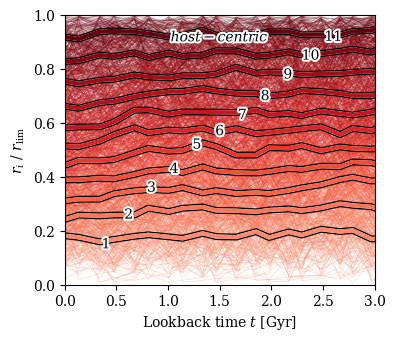

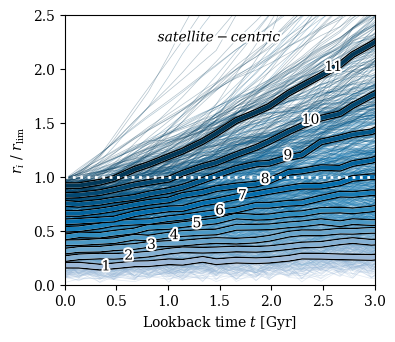

In [32]:
fig, ax = plt.subplots(figsize=(4,3.5))

for i_MW in range(len(subset)):

    alpha = .3

    for i in range (N_sat):
        a = 1.#     print ("i")
        ax.plot(lookback_times[0:N_snap], np.sort(r_z_trans[i_MW,:,:], axis=1)[:,i]  / r_lim[subset[i_MW],:], lw = .5, color = colors_trans[i], alpha= alpha) 

# median ratio of the i_th most distant subhalo and r_lim.
median_values =  np.median(np.sort(r_z_trans / r_lim[subset,:,np.newaxis], axis=2)[:, :, :], axis=0)

for i in range (N_sat):
    ax.plot(lookback_times[0:N_snap], median_values[:,i], lw = 3, color = colors_trans[i], alpha= 1, path_effects = pe) 


ax.set(xlabel='Lookback time '+r'$t$'+' [Gyr]', ylabel=r'$r_i \ / \ r_\mathrm{lim}$')
ax.set_xlim(0,np.round(lookback_times[N_snap-1]))
ax.set_ylim(0,1.0)


ax.text(0.5, 0.92, r'$host-centric$', ha='center', va='center', transform=ax.transAxes, 
                        path_effects=[patheffects.withStroke(linewidth=3, foreground='white', capstyle="round")],
                        )


x = np.linspace(0.4, 2.6, N_sat)
y = np.linspace(0.18, 0.9, N_sat)

print ("y:", y)
y = np.array([0.15,  0.26, 0.36, 0.43, 0.52, 0.57,  0.63, 0.70, 0.78, 0.85, 0.92]  )

if paper_annotations:
    for i in range(N_sat):
        ax.text(x[i], y[i], str(i+1), ha='center', va='center', 
                path_effects=[patheffects.withStroke(linewidth=3, foreground='white', capstyle="round")],
                transform=ax.transData)


fig.savefig(plot_dir+"/"+"distance_vs_rlim_time_transient.pdf", bbox_inches='tight')


fig, ax = plt.subplots(figsize=(4,3.5))

for i_MW in range(len(subset)):

    alpha = .3

    if i_MW != 11:
        
        for i in range (N_sat):
            a = 1.#     print ("i")
            ax.plot(lookback_times[0:N_snap], np.sort(r_z_pers[i_MW,:,:], axis=1)[:,i]  / r_lim[subset[i_MW],:], lw = .5, color = colors_pers[i], alpha= alpha) 

# average ratio of the i_th most distant subhalo and r_lim.
median_values =  np.median(np.sort(r_z_pers / r_lim[subset,:,np.newaxis], axis=2)[:, :, :], axis=0)

for i in range (N_sat):
    ax.plot(lookback_times[0:N_snap], median_values[:,i], lw = 3, color = colors_pers[i], alpha= 1, path_effects = pe) 


#ax.plot(lookback_times[0:N_snap], np.mean(r_lim, axis = 0) / hubble * scalefactors[0:N_snap], lw = 3., color = 'black')

ax.set(xlabel='Lookback time '+r'$t$'+' [Gyr]', ylabel=r'$r_i \ / \ r_\mathrm{lim}$')
ax.set_xlim(0,np.round(lookback_times[N_snap-1]))
ax.set_yticks([0,0.5,1.,1.5,2,2.5])
ax.set_ylim(0,2.5)

ax.axhline(1., ls = 'dotted', color = 'white', lw = 2)


x = np.linspace(0.4, 2.6, N_sat)
y = np.array([0.17, 0.27, 0.37, 0.46, 0.57, 0.69, 0.83, 0.98, 1.2, 1.53, 2.02])

ax.text(0.5, 0.92, r'$satellite-centric$', ha='center', va='center', transform=ax.transAxes, 
                        path_effects=[patheffects.withStroke(linewidth=3, foreground='white', capstyle="round")],
                        )
if paper_annotations:
    for i in range(N_sat):
        ax.text(x[i], y[i], str(i+1), ha='center', va='center', 
                path_effects=[patheffects.withStroke(linewidth=3, foreground='white', capstyle="round")],
                transform=ax.transData)


fig.savefig(plot_dir+"/"+"distance_vs_rlim_time_persistent.pdf", bbox_inches='tight')


## Plot spatial distribution of satellites

We plot $t=0$, and every 3rd output until $t \sim 3$ Gyr

lookback times [0.    0.475 1.008 1.466 1.979 2.48  2.969]
i_MW: 36
subhalo number: 503987
i_MW: 36 ID: 503987 style solid
i_MW: 15
subhalo number: 458470
i_MW: 15 ID: 458470 style (0, (6, 1.5))
i_MW: 35
subhalo number: 502995
i_MW: 35 ID: 502995 style (0, (2, 1.5))
i_MW: 40
subhalo number: 506720
i_MW: 40 ID: 506720 style (0, (4, 1.5, 2, 1.5))


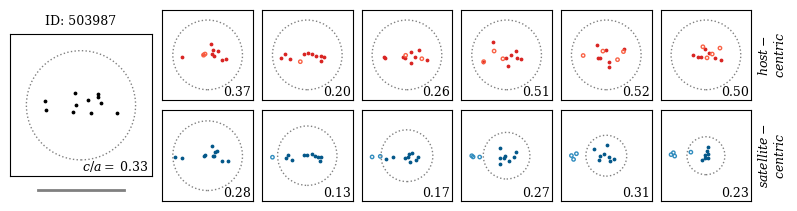

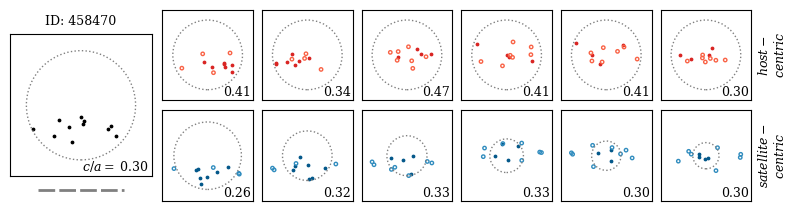

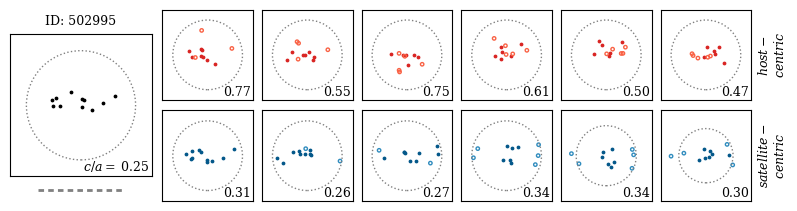

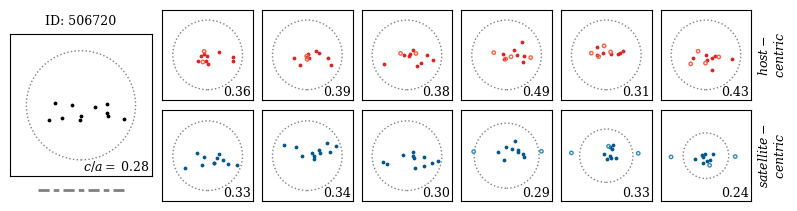

In [33]:
if paper_annotations:
    
    snapshots = [0,3,6,9,12,15,18]
    
    print ("lookback times", lookback_times[snapshots])
    
    N_x = len(snapshots)
    
    count = 0
    
    for i_MW in highlighted :
        
        print ("i_MW:", i_MW)
     
        # Create figure
        fig = plt.figure(figsize=(N_x*1.55, 2.5))
        
        # Create grid spec: 2 rows, 2 columns
        # Left column will be for z=0 (both rows)
        # Right column will be split into two rows with multiple panels each
        gs = GridSpec(2, 2, figure=fig, width_ratios=[1, 1+N_x*0.55], height_ratios=[1, 1], wspace=.025)
        
        # Large left panel (spans both rows, first column)
        ax_left = fig.add_subplot(gs[:, 0])
        
        gs_right = gs[:, 1].subgridspec(2, N_x, hspace=0.1, wspace=0.1)    
        ax = []
        
        for i in range(2):
            row_axes = []
            for j in range(N_x-1):
                newax = fig.add_subplot(gs_right[i, j])
                row_axes.append(newax)
            ax.append(row_axes)
    
        ax = np.array(ax)
        
        # t = 0
    
        # positions relative to the centre:
        positions = np.remainder(satellites_pos_z_pers[subset[i_MW],:,0,:] - MW_pos_z[subset[i_MW],0,None,:] 
                       + boxSize/2., boxSize) - boxSize/2.
        
        evals, evecs = inertiatensor(  positions )
    
        coords_prime =  np.dot(positions, evecs).T
        
        ax_left.scatter(coords_prime[0][:], coords_prime[2][:], color = 'black', s=3)
    
        plot_range = r_lim[i_MW,0] * 1.3
            
        ax_left.set_xlim(-plot_range, plot_range)
        ax_left.set_ylim(-plot_range, plot_range)
    
        circle1 = plt.Circle((0, 0), r_lim[i_MW,0], facecolor = 'none', edgecolor='grey', ls = 'dotted', lw = 1 )
        ax_left.add_patch(circle1)
    
        # c/a
        ax_left.text(0.98, 0.02, r'$c/a=$ '+f"{ca_z_pers[i_MW,0]:.2f}", ha = 'right', va = 'bottom', transform =  ax_left.transAxes, fontsize=9)
    
        # subhalo number    
        ax_left.text(0.5, 1.05, r'ID: '+str(MW_ID_z0[subset[i_MW]]), ha = 'center', va = 'bottom', transform =  ax_left.transAxes, fontsize=9)
        print ("subhalo number:", MW_ID_z0[subset[i_MW]])
    
        print ("i_MW:", i_MW, 'ID:', MW_ID_z0[subset[i_MW]], "style", styles[count])
        
        # line style to identify it.
        ax_left.plot([0.2, 0.8], [- 0.1, - 0.1], ls = styles[count], color = 'grey', lw = 2., 
                     clip_on=False, zorder=100, transform = ax_left.transAxes)
    
        count = count + 1
        
        for i_snap, snap in enumerate(snapshots[1:]):
    
            positions_trans = np.remainder(satellites_pos_z_trans[subset[i_MW],:,snap,:] -MW_pos_z[subset[i_MW],snap,np.newaxis] 
                       + boxSize/2., boxSize) - boxSize/2.
    
    
            positions_pers = np.remainder(satellites_pos_z_pers[subset[i_MW],:,snap,:] -MW_pos_z[subset[i_MW],snap,np.newaxis] 
                       + boxSize/2., boxSize) - boxSize/2.
    
    
            # TRANS
            
            evals, evecs = inertiatensor(  positions_trans )
            coords_prime =  np.dot(positions_trans, evecs).T
    
            # identify the subhalos that are present at z=0: they will have the same positions as in the "persistent" frame.
    
            idx_new = []
            idx_OG = []
            
            for i in range(N_sat):
                distance = np.min(np.linalg.norm(positions_trans[i,np.newaxis,:] - positions_pers[:,:], axis=1 ), axis = 0)
    
                if distance < 1.e-5:
                    idx_OG.append(i)
                else:
                    idx_new.append(i)
    
            ax[0,i_snap].scatter(coords_prime[0][idx_OG], coords_prime[2][idx_OG], color = c_trans_0, s=3)
            ax[0,i_snap].scatter(coords_prime[0][idx_new], coords_prime[2][idx_new], facecolor='none', edgecolor = c_trans_1, s=6)
    
            plot_range = r_lim[i_MW,i_snap] * 1.3
            
            ax[0,i_snap].set_xlim(-plot_range, plot_range)
            ax[0,i_snap].set_ylim(-plot_range, plot_range)
    
    
            
            # PERS
    
            evals, evecs = inertiatensor(  positions_pers )
            coords_prime =  np.dot(positions_pers, evecs).T
    
            inside = np.where(r_z_pers[i_MW, snap,:] <= r_lim[i_MW, snap, np.newaxis])[0]
            outside = np.where(r_z_pers[i_MW, snap,:] > r_lim[i_MW, snap, np.newaxis])[0]
    
            ax[1,i_snap].scatter(coords_prime[0][inside], coords_prime[2][inside], color = c_pers_0, s=3)
            ax[1,i_snap].scatter(coords_prime[0][outside], coords_prime[2][outside], facecolor='none', edgecolor = c_pers_1, s=6)
    
            plot_range = np.max([np.max(np.abs(coords_prime)) * 1.3, r_lim[i_MW,i_snap] * 1.3])
    
            ax[1,i_snap].set_xlim(-plot_range, plot_range)
            ax[1,i_snap].set_ylim(-plot_range, plot_range)
    
            
            ## ANNOTATIONS
    
            ax[0,i_snap].text(0.98, 0.02, f"{ca_z_trans[i_MW,snap]:.2f}", ha = 'right', va = 'bottom', transform =  ax[0,i_snap].transAxes, fontsize=9)
            ax[1,i_snap].text(0.98, 0.02, f"{ca_z_pers[i_MW,snap]:.2f}", ha = 'right', va = 'bottom', transform =  ax[1,i_snap].transAxes, fontsize=9)
    
            circle1 = plt.Circle((0, 0), r_lim[i_MW,i_snap], facecolor = 'none', edgecolor='grey', ls = 'dotted', lw = 1 )
            ax[0,i_snap].add_patch(circle1)
            circle1 = plt.Circle((0, 0), r_lim[i_MW,i_snap], facecolor = 'none', edgecolor='grey', ls = 'dotted', lw = 1 )
            ax[1,i_snap].add_patch(circle1)
    
    
        
        for ind_x in range(0,N_x-1):
            for ind_y in range(2):
            
                ax[ind_y,ind_x].set_xticks([])
                ax[ind_y,ind_x].set_yticks([])
                ax[ind_y,ind_x].set_aspect('equal', adjustable='box')
    
        ax[0,N_x-2].text(1.23, 0.5, r'$host-$'+'\n'+r'$centric$', ha = 'center', va = 'center',  rotation='vertical', transform =  ax[0,N_x-2].transAxes, fontsize=9)
        ax[1,N_x-2].text(1.23, 0.5, r'$satellite-$'+'\n'+r'$centric$', ha = 'center', va = 'center',  rotation='vertical', transform =  ax[1,N_x-2].transAxes, fontsize=9)
    
        ax_left.set_aspect('equal', adjustable='box')
        ax_left.set_xticks([])
        ax_left.set_yticks([])   
    
        fig.savefig(plot_dir+"/"+"positions_every3_"+str(i_MW)+".pdf", bbox_inches='tight')

### Plot histograms of the lifetimes

#### _persistent_ picture

threshold: 0.3420145576693769


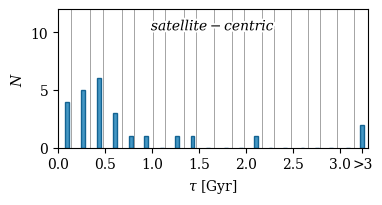

In [34]:
N_low = 25
x = np.percentile(ca_z_trans[:,0], 25)
print ("threshold:", x)


# PERS

first_indices = np.where(
    (mask := ca_z_pers[idx_sorted_ca_pers[0:N_low]] > x).any(axis=1),
    np.argmax(mask, axis=1),
    N_snap)

survival_times_pers = np.array(lookback_times)[first_indices[0:N_low] - 1] 

# PLOT

fig, ax = plt.subplots(figsize=(4,1.8))

bins = lookback_times[0:N_snap+1]

hist_pers, bin_edges = np.histogram(survival_times_pers, bins=bins)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

ax.bar(bin_centers+.03, hist_pers, bottom=0, edgecolor=c_pers_0, color = c_pers_1, width=.04, alpha = .9, label = r'$satellite-centric$')

ax.set(xlabel=r'$\tau$ [Gyr]', ylabel=r'$N$')
ax.set_xlim(0,3.3)
ax.set_ylim(0,12)
ax.set_xticks([0, 0.5, 1., 1.5, 2.,2.5, 3, 3.24])
ax.set_xticklabels(["0.0", "0.5", "1.0", "1.5", "2.0", "2.5", "3.0", ">3"])

ax.vlines(np.array(lookback_times[0:N_snap]) , ymin=0, ymax=250, ls = 'solid', lw = 0.5, color ='grey')


ax.text(0.5, 0.88, r'$satellite-centric$', ha='center', va='center', transform=ax.transAxes, 
                        path_effects=[patheffects.withStroke(linewidth=3, foreground='white', capstyle="round")],
                        )

#ax.legend(ncols = 2, loc = 'upper center')

fig.savefig(plot_dir+"/"+"survival_plane_persistent.pdf", bbox_inches='tight')


#### _transient_ picture

threshold: 0.3420145576693769


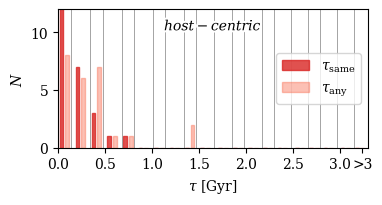

In [35]:
N_low = 25
x = np.percentile(ca_z_trans[:,0], 25)

print ("threshold:", x)


first_indices = np.where(
    (mask := ca_z_trans[idx_sorted_ca_trans[0:N_low]] > x).any(axis=1),
    np.argmax(mask, axis=1),
    N_snap)

survival_times_trans_same = np.array(lookback_times)[np.min([first_changed[0:N_low], first_indices[0:N_low]], axis=0) - 1]

survival_times_trans_any = np.array(lookback_times)[first_indices[0:N_low]- 1]

# PLOT

fig, ax = plt.subplots(figsize=(4,1.8))

bins = lookback_times[0:N_snap+1]

hist_trans_any, bin_edges = np.histogram(survival_times_trans_any, bins=bins)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

hist_trans_same, bin_edges = np.histogram(survival_times_trans_same, bins=bins)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2


ax.bar(bin_centers-.03, hist_trans_same, bottom=0, edgecolor=c_trans_0, color = c_trans_0, width=.04, alpha = .8, label = r'$\tau_\mathrm{same}$')
ax.bar(bin_centers+.03, hist_trans_any, bottom=0, edgecolor=c_trans_1, color = c_trans_1, width=.04, alpha = .4, label = r'$\tau_\mathrm{any}$')

ax.set(xlabel=r'$\tau$ [Gyr]', ylabel=r'$N$')
ax.set_xlim(0,3.3)
ax.set_ylim(0,12)
ax.set_xticks([0, 0.5, 1., 1.5, 2.,2.5, 3, 3.24])
ax.set_xticklabels(["0.0", "0.5", "1.0", "1.5", "2.0", "2.5", "3.0", ">3"])

ax.vlines(np.array(lookback_times[0:N_snap]) , ymin=0, ymax=250, ls = 'solid', lw = 0.5, color ='grey')


ax.text(0.5, 0.88, r'$host-centric$', ha='center', va='center', transform=ax.transAxes, 
                        path_effects=[patheffects.withStroke(linewidth=3, foreground='white', capstyle="round")],
                        )

ax.legend(ncols = 1, loc = 'center right')

fig.savefig(plot_dir+"/"+"survival_plane_transient.pdf", bbox_inches='tight')


In [36]:
print ("median rlim (subset, z0):", np.median(r_lim[subset,0] / hubble) )

print ("\n\nfull sample")
print ("length of the full sample:", len(MW_M200_z0))
print ("Median mass:", np.percentile(MW_M200_z0, 50) / 1.e12 )
print ("-:", (np.percentile(MW_M200_z0, 15.865) - np.percentile(MW_M200_z0, 50)) / 1.e12 ) 
print ("+:", (np.percentile(MW_M200_z0, 84.135) - np.percentile(MW_M200_z0, 50)) / 1.e12 ) 

print ("r200:", np.percentile(r_lim[:,0], 50) / r200_factor / hubble )
print ("+:", (np.percentile(r_lim[:,0], 15.865) - np.percentile(r_lim[subset,0], 50)) / hubble ) 
print ("-:", (np.percentile(r_lim[:,0], 84.135) - np.percentile(r_lim[subset,0], 50)) / hubble ) 

print ("\n\nsubset:")
print ("length of subset:", len(subset))

print ("mass:", np.percentile(MW_M200_z0[subset], 50) / 1.e12 )
print ("+:", (np.percentile(MW_M200_z0[subset], 15.865) - np.percentile(MW_M200_z0[subset], 50)) / 1.e12 ) 
print ("-:", (np.percentile(MW_M200_z0[subset], 84.135) - np.percentile(MW_M200_z0[subset], 50)) / 1.e12 ) 


print ("r200:", np.percentile(r_lim[subset,0], 50) / r200_factor / hubble )
print ("+:", (np.percentile(r_lim[subset,0], 15.865) - np.percentile(r_lim[subset,0], 50)) / hubble ) 
print ("-:", (np.percentile(r_lim[subset,0], 84.135) - np.percentile(r_lim[subset,0], 50)) / hubble ) 


median rlim (subset, z0): 276.2349446614583


full sample
length of the full sample: 190
Median mass: 1.356120850432
-: -0.5351222345236479
+: 1.133690311750451
r200: 233.87259074217596
+: -37.872589517913816
-: 66.82176811166454


subset:
length of subset: 101
mass: 1.301084110848
+: -0.4302405382963199
-: 1.0803036658073604
r200: 230.19578721788199
+: -34.602019988860484
-: 61.66777203911556
